human
Unaligned:  1399
Weakly aligned:  1435
Pct. genes unaligned:  0.924
mouse
Unaligned:  410
Weakly aligned:  487
Pct. genes unaligned:  0.977
Gene type bars plotted


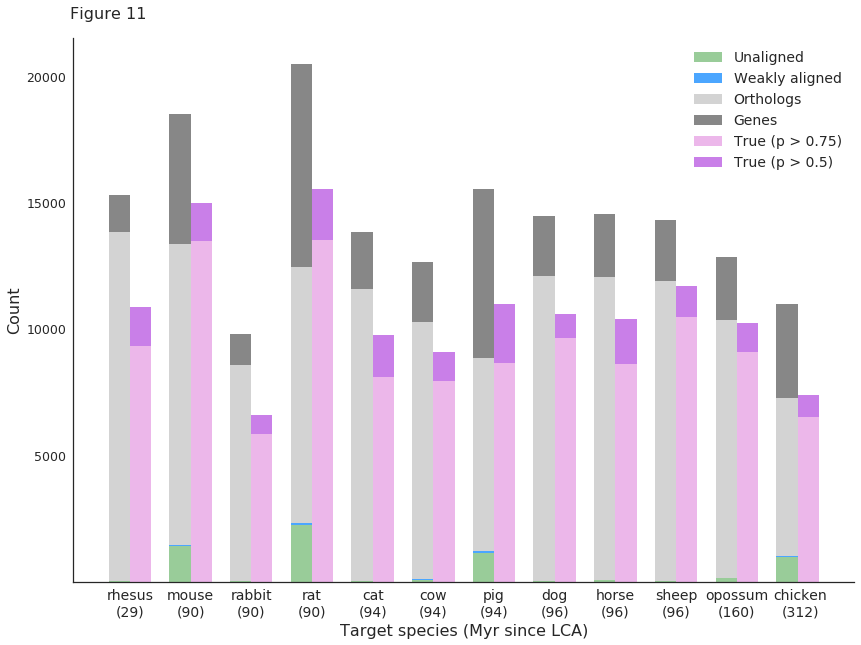

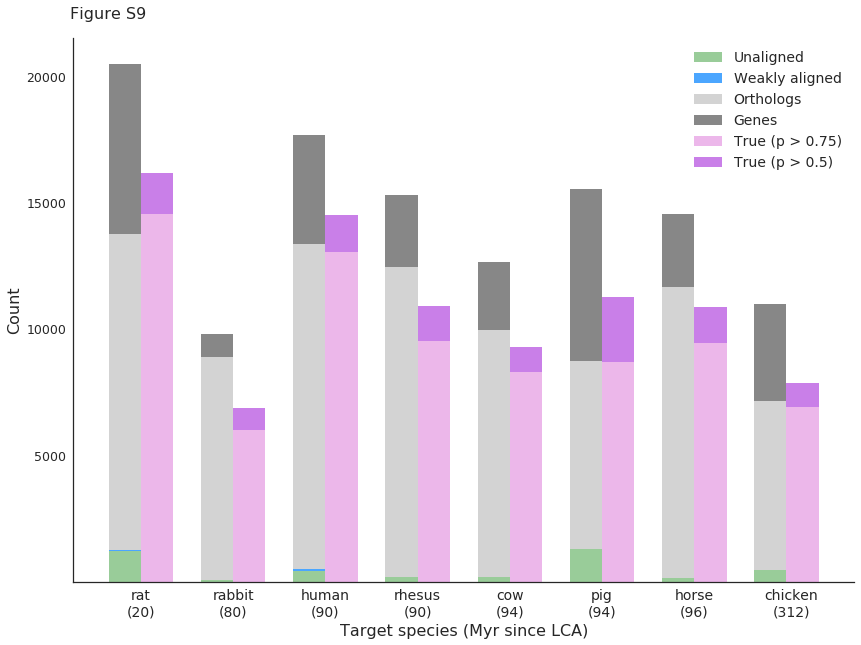

In [2]:
%matplotlib inline

import os as os
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn

import pandas as pd
import numpy as np
import numpy.random as rng
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

# What is this?
# Stacked bar charts of number of genes,
# number of orthologs and number of un-/weakly
# aligned genes

date = '20180430'

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
project_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm')
traindata_folder = os.path.join(project_folder, 'task_traindata_exp/train_datasets')
testdata_folder = os.path.join(project_folder, 'task_testdata_exp/test_datasets')
ortholog_folder = os.path.join(fhgfs_base, 'refdata/orthologs/hdf')

ortholog_file = os.path.join(ortholog_folder, 'odb9_gene-orthologs.h5')

cache_dir = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/caching/notebooks')
dump_folder = os.path.join(project_folder, 'task_summarize/wkaln_unaln_genes')

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
ref_folder = '/home/pebert/work/code/mpggit/refdata/annotation'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))
lca_times_file = os.path.join(ref_folder, 'lca_dist.tsv')
species_file = os.path.join(ref_folder, 'species.tsv')

run_exec_gene_bars = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True


def exec_gene_bars():
    cache_file = os.path.join(cache_dir, '{}_plot_unaln_ortho_bars.pck'.format(date))
    
    true_pred_cache = os.path.join(cache_dir, '20180314_plot_perfcomp_prob.h5')
    true_preds = load_true_predictions(true_pred_cache)
    
    if os.path.isfile(cache_file):
        gene_bars = cache_data(cache_file, None)
    else:
        gene_bars = collect_gene_types(true_preds)
        gene_bars = cache_data(cache_file, gene_bars)
    
    species, lca = read_references(species_file, lca_times_file)
    
    trg_species = set(list(species.keys())) - set(['frog', 'lizard'])
    
    for ref, fk, subfolder in zip(['human', 'mouse'], ['11', 'S9'], ['main', 'supp']):
    
        fig, exart = plot_gene_bars(gene_bars, ref, lca, fk)
                               
        if save_figures:
            outname = 'fig_{}_gene-bars'.format(fk)
            
            outpath = os.path.join(out_folder, subfolder, 'raw', outname + '.svg')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')

            outpath = os.path.join(out_folder, subfolder, 'png', outname + '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)

            outpath = os.path.join(out_folder, subfolder, outname + '.pdf')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
    
    return True


def load_true_predictions(true_pred_cache):
    
    tlo = 'pred_prob_lo_50'
    thi = 'pred_prob_lo_75'
    
    true_counts = col.defaultdict(list)
    with pd.HDFStore(true_pred_cache, 'r') as hdf:
        load_keys = [k for k in hdf.keys() if k.endswith('/true/model')]
        for k in load_keys:
            _, trg, qry, _, _ = k.split('/')
            data = hdf[k]
            true_counts[(trg, qry, 'tlo')].append(data[tlo].mean().round(0))
            true_counts[(trg, qry, 'thi')].append(data[thi].mean().round(0))
    mean_counts = dict()
    for k, v in true_counts.items():
        mean = int(np.mean(v).round(0))
        mean_counts[k] = mean
    return mean_counts
            

def cache_data(cache_file, genebars):
    
    if os.path.isfile(cache_file):
        with open(cache_file, 'rb') as cache:
            genebars = pck.load(cache)
    else:
        with open(cache_file, 'wb') as cache:
            _ = pck.dump(genebars, cache)
    return genebars


def extract_auc_values(perf_data, ref, trg, comparison):
    
    collector = []
    for (r, t, c, d), values in perf_data.items():
        if d == 'auc' and c == comparison:
            if r == ref and (t == trg or trg == 'all' or t in trg):
                collector.extend(values)
    return np.array(collector, dtype=np.float64).round(2)
    
    
def plot_gene_bars(gene_counts, ref_spec, lca_dist, fkey):
    """
    """
    fig, ax = plt.subplots(figsize=(14, 10))
    extra_artists = []
    
    bar_width = 0.35
        
    unaln = [(lca_dist[(t, q)], q, v) for (t, q, label), v in gene_counts.items() if label == 'unaln' and t == ref_spec and q != ref_spec]
    
    tlo = [(lca_dist[(t, q)], q, v) for (t, q, label), v in gene_counts.items() if label == 'tlo' and t == ref_spec and q != ref_spec]
    thi = [(lca_dist[(t, q)], q, v) for (t, q, label), v in gene_counts.items() if label == 'thi' and t == ref_spec and q != ref_spec]
    
    aligned_queries = [t[1] for t in unaln]
    
    wkaln = [(lca_dist[(t, q)], q, v) for (t, q, label), v in gene_counts.items() if label == 'wkaln' and t == ref_spec and q != ref_spec]
    ortho = [(lca_dist[(t, q)], q, v) for (t, q, label), v in gene_counts.items() \
             if label == 'ortho' and t == ref_spec and q != ref_spec and q in aligned_queries]
    total = [(lca_dist[(t, q)], q, v) for (t, q, label), v in gene_counts.items() if label == 'total' and t == ref_spec and q != ref_spec]
        
    bad_ortho = [(lca_dist[(t, q)], q, v) for (t, q, label), v in gene_counts.items() if label == 'bad_ortho' and t == ref_spec and q != ref_spec]
    
    unaln = sorted(unaln)
    
    x_vals = np.arange(1, len(unaln) + 1, step=1, dtype=np.float32)
    x_labels = ['{}\n({})'.format(t[1], t[0]) for t in unaln]
        
    unaln = np.array([t[2] for t in unaln], dtype=np.int32)
    wkaln = np.array([t[2] for t in sorted(wkaln)], dtype=np.int32)
    wkaln += unaln  # turn this into absolute height for uniform handling
    ortho = np.array([t[2] for t in sorted(ortho)], dtype=np.int32)
    total = np.array([t[2] for t in sorted(total)], dtype=np.int32)
    
    tlo = np.array([t[2] for t in sorted(tlo)], dtype=np.int32)
    thi = np.array([t[2] for t in sorted(thi)], dtype=np.int32)
    
    ### Output for publication
    print('=========')
    print(ref_spec)
    if ref_spec == 'human':
        idx = 1
    else:
        idx = 2
    print('Unaligned: ', unaln[idx])
    print('Weakly aligned: ', wkaln[idx])
    print('Pct. genes unaligned: ', 1 - np.round(unaln[idx] / total[idx], 3))
    print('=========')
        
    bottom = np.zeros_like(unaln, dtype=np.int32)
    y_values = [unaln, wkaln, ortho, total]
    labels = ['Unaligned', 'Weakly aligned', 'Orthologs', 'Genes']
    colors = ['green', 'dodgerblue', 'lightgrey', 'dimgrey']
    alphas = [0.4, 0.8, 1, 0.8]
    
    for yv, l, c, a in zip(y_values, labels, colors, alphas):
        next_bottom = yv.copy()
        yv -= bottom             
        ax.bar(x_vals, yv, bottom=bottom,
               label=l, color=c, alpha=a,
               align='edge', width=bar_width)
        bottom = next_bottom
    
    # added bars for true predictions
    x_vals += bar_width
    ax.bar(x_vals, thi, label='True (p > 0.75)', align='edge',
           color='orchid', alpha=0.5, width=bar_width)
    ax.bar(x_vals, tlo - thi, label='True (p > 0.5)', align='edge',
           bottom=thi, color='darkviolet', alpha=0.5, width=bar_width)
    
    ax.legend(loc='upper right', fontsize=14)
    
    ax.set_yticks([5000, 10000, 15000, 20000])
    x_ticks = x_vals
    x_ticks[-1] += 0.05
    ax.set_xticks(x_vals)
    ax.set_xticklabels(x_labels, fontsize=14)
    
    ax.set_xlabel('Target species (Myr since LCA)', fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    tt = ax.set_title('Figure {}'.format(fkey), fontsize=16)
    tt.set_position([0.045, 1.025])
    
    return fig, extra_artists


def read_references(species, lca):
    """
    """
    lca_dist = dict()
    with open(lca_times_file, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            if r['timetree-org'] in ['human', 'mouse']:
                src = r['timetree-org']
                for k, v in r.items():
                    if k.startswith('time'):
                        continue
                    lca_dist[(src, k)] = int(v)
            else:
                break
    
    spec_ann = dict()
    with open(species, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            spec_ann[r['common_name']] = r

    return spec_ann, lca_dist
  

def collect_gene_types(true_counts):
    print('collecting')
    gene_collector = col.Counter()
    feat_columns = ['chrom', 'name', 'symbol',
                    'start_body', 'end_body',
                    'start_reg5p', 'end_reg5p',
                    'ftlen_abs_length_reg5p',
                    'ftmsig_H3K4me3_pct_cons_reg5p',
                    'ftlen_abs_length_body',
                    'ftmsig_H3K36me3_pct_cons_body']
    
    ortho_genes = dict()
    with pd.HDFStore(ortholog_file, 'r') as hdf:
        load_keys = [k for k in hdf.keys() if k.startswith('/auto/pairs')]
        for k in load_keys:
            _, _, _, s1, s2 = k.split('/')
            if s1 == 'human' or s1 == 'mouse':
                trg = s1
                qry = s2
            elif s2 == 'human' or s2 == 'mouse':
                trg = s2
                qry = s1
            else:
                continue
            data = hdf[k]
            genes1 = set(data['{}_name'.format(s1)].tolist())
            genes2 = set(data['{}_name'.format(s2)].tolist())
            ortho_genes[(trg, qry)] = genes1.union(genes2)
            gene_collector[(trg, qry, 'ortho')] = data.shape[0]
    
    for root, dirs, featfiles in os.walk(testdata_folder):
        if featfiles:
            featfiles = [ff for ff in featfiles if ff.startswith('G9930') and ff.endswith('.feat.h5')]
            for ff in featfiles:
                fpath = os.path.join(root, ff)
                out_buffer = []
                trg, qry = None, None
                cc = 0
                with pd.HDFStore(fpath, 'r') as hdf:
                    for k in hdf.keys():
                        if k.startswith('/metadata'):
                            continue
                        data = hdf[k]
                        _, qry, _, trg, _, _, chrom = k.split('/')
                        qry = plot_colors['mapping'][qry]['species']
                        trg = plot_colors['mapping'][trg]['species']
                        cc += 1
                        data['chrom'] = chrom
                        data = data.loc[:, feat_columns].copy()
    
                        data['promoter_cons_bp'] = (data['ftlen_abs_length_reg5p'] * \
                                                    (data['ftmsig_H3K4me3_pct_cons_reg5p'] / 100.)).round(0).astype(np.int32)
                        data['body_cons_bp'] = (data['ftlen_abs_length_body'] * \
                                               (data['ftmsig_H3K36me3_pct_cons_body'] / 100.)).round(0).astype(np.int32)

                        data['unaln'] = ((data['body_cons_bp'] < 1) & (data['promoter_cons_bp'] < 1)).astype(np.int8)
                        data['wkaln'] = ((data['body_cons_bp'] < 100) & (data['promoter_cons_bp'] < 100)).astype(np.int8)
                    
                        unaln = data['unaln'].sum()
                        wkaln = data['wkaln'].sum()
                        
                        gene_collector[(trg, qry, 'unaln')] += unaln
                        gene_collector[(trg, qry, 'wkaln')] += (wkaln - unaln)
                        gene_collector[(trg, qry, 'total')] += data.shape[0]
                        
                        sub_select = np.logical_or(data['unaln'] > 0, data['wkaln'] > 0)
                        
                        data = data.loc[sub_select, :].copy()
                        
                        data['is_ortholog'] = (data['name'].isin(ortho_genes[(trg, qry)])).astype(np.int8)
                        gene_collector[(trg, qry, 'bad_ortho')] = data['is_ortholog'].sum()
                        
                        out_buffer.append(data)
                        
                dump_file = os.path.join(dump_folder, '{}_from_{}.bad-aln.tsv'.format(qry, trg))
                #assert not os.path.isfile(dump_file), 'Duplicate created: {}'.format(dump_file)
                out_dump = pd.concat(out_buffer, axis=0, ignore_index=False)
                out_dump.sort_values(['chrom', 'start_reg5p', 'end_reg5p'], inplace=True)
                out_dump.to_csv(dump_file, sep='\t', header=True, index=False, mode='w')
    gene_collector.update(true_counts)
    return gene_collector


if run_exec_gene_bars:
    execd = exec_gene_bars()
    print('Gene type bars plotted')
